In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from ucimlrepo import fetch_ucirepo 
import xgboost as xgb
  
# fetch dataset 
regensburg_pediatric_appendicitis = fetch_ucirepo(id=938) 
  
# data (as pandas dataframes) 
X = regensburg_pediatric_appendicitis.data.features 
y = regensburg_pediatric_appendicitis.data.targets

# Merging X and y to data
data = pd.merge(X, y, left_index=True, right_index=True)
data.shape

(782, 56)

In [2]:
# deleting not needed target variables from data
data = data.drop(['Management', 'Severity'], axis=1)
data.shape

(782, 54)

In [3]:
# removing all NAN values from diagnosis
data = data.dropna(subset=['Diagnosis'])
data.shape

(780, 54)

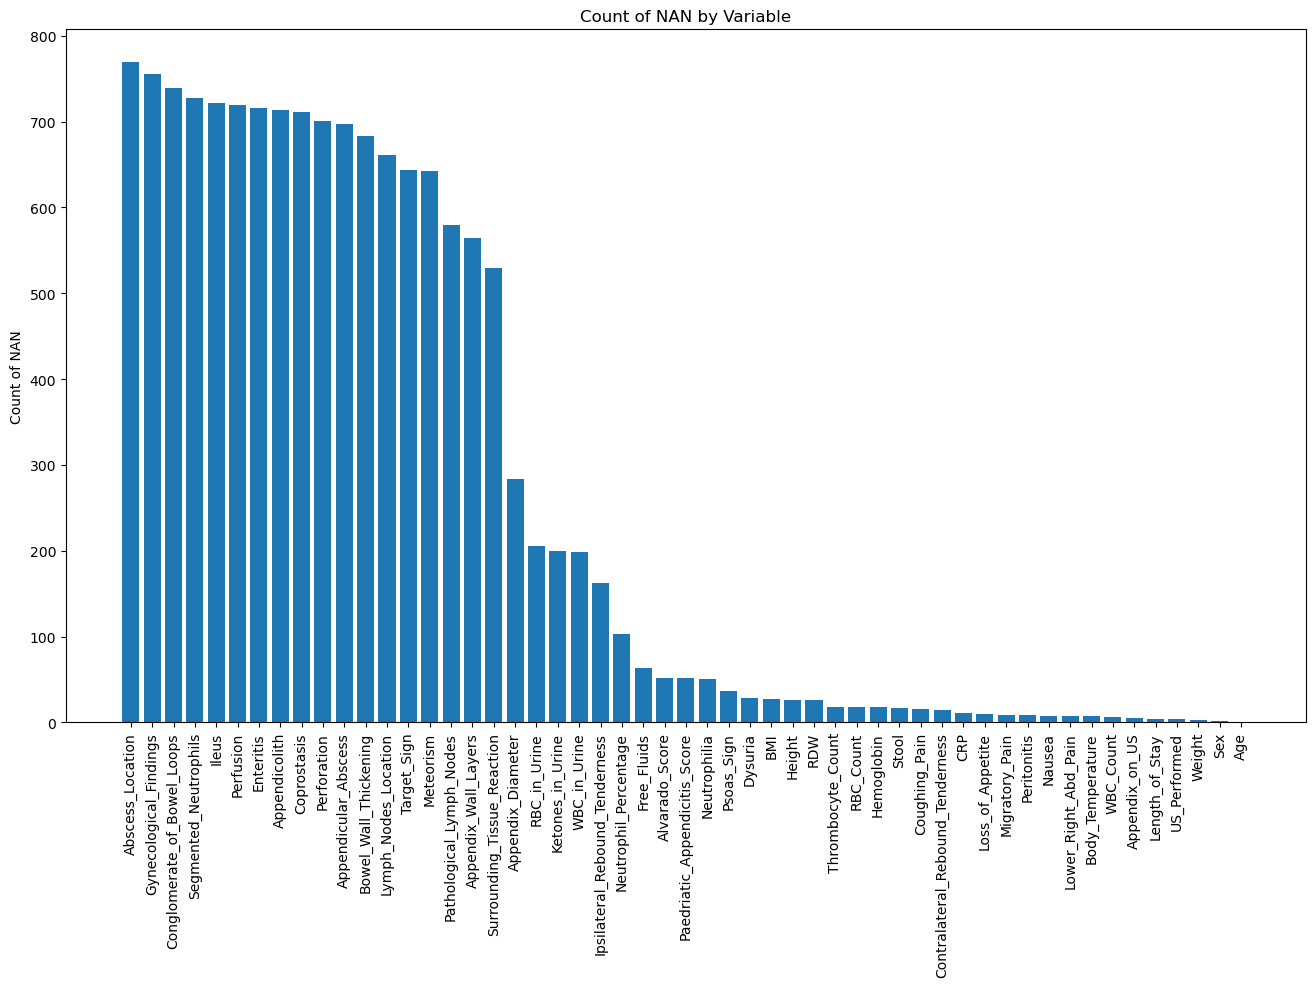

In [4]:
# visualizing count of NAN values
nan_counts = X.isna().sum()
nan_counts_sorted = nan_counts.sort_values(ascending=False)  # Sort values in descending order

plt.figure(figsize=(16, 9))
plt.bar(nan_counts_sorted.index, nan_counts_sorted.values)
plt.xticks(rotation=90)
plt.title('Count of NAN by Variable')
plt.ylabel('Count of NAN')
plt.show()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 780 entries, 0 to 781
Data columns (total 54 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               780 non-null    float64
 1   BMI                               754 non-null    float64
 2   Sex                               779 non-null    object 
 3   Height                            755 non-null    float64
 4   Weight                            778 non-null    float64
 5   Length_of_Stay                    777 non-null    float64
 6   Alvarado_Score                    730 non-null    float64
 7   Paedriatic_Appendicitis_Score     730 non-null    float64
 8   Appendix_on_US                    777 non-null    object 
 9   Appendix_Diameter                 498 non-null    float64
 10  Migratory_Pain                    773 non-null    object 
 11  Lower_Right_Abd_Pain              774 non-null    object 
 12  Contralateral

In [6]:
object_columns = data.select_dtypes(include=['object'])
object_columns.columns

Index(['Sex', 'Appendix_on_US', 'Migratory_Pain', 'Lower_Right_Abd_Pain',
       'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea',
       'Loss_of_Appetite', 'Neutrophilia', 'Ketones_in_Urine', 'RBC_in_Urine',
       'WBC_in_Urine', 'Dysuria', 'Stool', 'Peritonitis', 'Psoas_Sign',
       'Ipsilateral_Rebound_Tenderness', 'US_Performed', 'Free_Fluids',
       'Appendix_Wall_Layers', 'Target_Sign', 'Appendicolith', 'Perfusion',
       'Perforation', 'Surrounding_Tissue_Reaction', 'Appendicular_Abscess',
       'Abscess_Location', 'Pathological_Lymph_Nodes', 'Lymph_Nodes_Location',
       'Bowel_Wall_Thickening', 'Conglomerate_of_Bowel_Loops', 'Ileus',
       'Coprostasis', 'Meteorism', 'Enteritis', 'Gynecological_Findings',
       'Diagnosis'],
      dtype='object')

In [7]:
# Transforming columns from text to numeric
data["Sex"] = data["Sex"].apply(lambda x: 1 if x == "female" else 0)
data["Appendix_on_US"] = data["Appendix_on_US"].apply(lambda x: 1 if x == "yes" else 0)
data["Migratory_Pain"] = data["Migratory_Pain"].apply(lambda x: 1 if x == "yes" else 0)
data["Lower_Right_Abd_Pain"] = data["Lower_Right_Abd_Pain"].apply(lambda x: 1 if x == "yes" else 0)
data["Contralateral_Rebound_Tenderness"] = data["Contralateral_Rebound_Tenderness"].apply(lambda x: 1 if x == "yes" else 0)
data["Coughing_Pain"] = data["Coughing_Pain"].apply(lambda x: 1 if x == "yes" else 0)
data["Nausea"] = data["Nausea"].apply(lambda x: 1 if x == "yes" else 0)
data["Loss_of_Appetite"] = data["Loss_of_Appetite"].apply(lambda x: 1 if x == "yes" else 0)
data["Neutrophilia"] = data["Neutrophilia"].apply(lambda x: 1 if x == "yes" else 0)

ketones_mapping = {"no": 0, "+": 1, "++": 2, "+++": 3}
data["Ketones_in_Urine"] = data["Ketones_in_Urine"].map(ketones_mapping)

rbc_mapping = {"no": 0, "+": 1, "++": 2, "+++": 3}
data["RBC_in_Urine"] = data["RBC_in_Urine"].map(rbc_mapping)

wbc_mapping = {"no": 0, "+": 1, "++": 2, "+++": 3}
data["WBC_in_Urine"] = data["WBC_in_Urine"].map(wbc_mapping)

data["Dysuria"] = data["Dysuria"].apply(lambda x: 1 if x == "yes" else 0)

stool_mapping = {"normal": 0, "diarrhea": 1, "constipation": 2, "constipation, diarrhea": 3}
data["Stool"] = data["Stool"].map(stool_mapping)

peritonitis_mapping = {"no": 0, "local": 1, "generalized": 2}
data["Peritonitis"] = data["Peritonitis"].map(peritonitis_mapping)

data["Psoas_Sign"] = data["Psoas_Sign"].apply(lambda x: 1 if x == "yes" else 0)
data["Ipsilateral_Rebound_Tenderness"] = data["Ipsilateral_Rebound_Tenderness"].apply(lambda x: 1 if x == "yes" else 0)
data["US_Performed"] = data["US_Performed"].apply(lambda x: 1 if x == "yes" else 0)
data["Free_Fluids"] = data["Free_Fluids"].apply(lambda x: 1 if x == "yes" else 0)

wall_mapping = {"intact": 0, "raised": 1, "partially raised": 2, "upset": 3}
data["Appendix_Wall_Layers"] = data["Appendix_Wall_Layers"].map(wall_mapping)

data.loc[:, "Target_Sign"] = data["Target_Sign"].apply(lambda x: 1 if x == "yes" else 0)

app_mapping = {"no": 0, "suspected": 1, "yes": 2}
data["Appendicolith"] = data["Appendicolith"].map(app_mapping)

perfusion_mapping = {"no": 0, "present": 1, "hypoperfused": 2, "hyperperfused": 3}
data["Perfusion"] = data["Perfusion"].map(perfusion_mapping)

perforation_mapping = {"no": 0, "suspected": 1, "not excluded": 2, "yes": 3}
data["Perforation"] = data["Perforation"].map(perfusion_mapping)

data.loc[:, "Surrounding_Tissue_Reaction"] = data["Surrounding_Tissue_Reaction"].apply(lambda x: 1 if x == "yes" else 0)

abscess_mapping = {"no": 0, "suspected": 1, "yes": 2}
data["Appendicular_Abscess"] = data["Appendicular_Abscess"].map(abscess_mapping)

data["Pathological_Lymph_Nodes"] = data["Pathological_Lymph_Nodes"].apply(lambda x: 1 if x == "yes" else 0)
data["Bowel_Wall_Thickening"] = data["Bowel_Wall_Thickening"].apply(lambda x: 1 if x == "yes" else 0)
data["Conglomerate_of_Bowel_Loops"] = data["Conglomerate_of_Bowel_Loops"].apply(lambda x: 1 if x == "yes" else 0)
data["Ileus"] = data["Ileus"].apply(lambda x: 1 if x == "yes" else 0)
data["Coprostasis"] = data["Coprostasis"].apply(lambda x: 1 if x == "yes" else 0)
data["Meteorism"] = data["Meteorism"].apply(lambda x: 1 if x == "yes" else 0)
data["Enteritis"] = data["Enteritis"].apply(lambda x: 1 if x == "yes" else 0)
data["Diagnosis"] = data["Diagnosis"].apply(lambda x: 1 if x == "appendicitis" else 0)

# Dropping columns
data.drop("Abscess_Location", axis=1, inplace=True)
data.drop("Lymph_Nodes_Location", axis=1, inplace=True)
data.drop("Gynecological_Findings", axis=1, inplace=True)

In [8]:
# Replacing NAN values with mean
nan_columns = data.columns[data.isna().any()].tolist()

data[nan_columns] = data[nan_columns].fillna(data.mean())

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 780 entries, 0 to 781
Data columns (total 51 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               780 non-null    float64
 1   BMI                               780 non-null    float64
 2   Sex                               780 non-null    int64  
 3   Height                            780 non-null    float64
 4   Weight                            780 non-null    float64
 5   Length_of_Stay                    780 non-null    float64
 6   Alvarado_Score                    780 non-null    float64
 7   Paedriatic_Appendicitis_Score     780 non-null    float64
 8   Appendix_on_US                    780 non-null    int64  
 9   Appendix_Diameter                 780 non-null    float64
 10  Migratory_Pain                    780 non-null    int64  
 11  Lower_Right_Abd_Pain              780 non-null    int64  
 12  Contralateral

## Principal Component Analysis

In [10]:
FEATURES = ['Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay',
       'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Appendix_on_US',
       'Appendix_Diameter', 'Migratory_Pain', 'Lower_Right_Abd_Pain',
       'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea',
       'Loss_of_Appetite', 'Body_Temperature', 'WBC_Count',
       'Neutrophil_Percentage', 'Segmented_Neutrophils', 'Neutrophilia',
       'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count',
       'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 'CRP', 'Dysuria',
       'Stool', 'Peritonitis', 'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness',
       'US_Performed', 'Free_Fluids', 'Appendix_Wall_Layers', 'Target_Sign',
       'Appendicolith', 'Perfusion', 'Perforation',
       'Surrounding_Tissue_Reaction', 'Appendicular_Abscess',
       'Pathological_Lymph_Nodes', 'Bowel_Wall_Thickening',
       'Conglomerate_of_Bowel_Loops', 'Ileus', 'Coprostasis', 'Meteorism',
       'Enteritis']

data_features = data[FEATURES]

data_features = StandardScaler().fit_transform(data_features)

In [20]:
number_comp = 2

pca = PCA(n_components=number_comp)
principalComponents = pca.fit_transform(data_features)

names = ["pc" + str(x) for x in range(1, number_comp + 1)]

principalDf = pd.DataFrame(data = principalComponents, columns=names)

print("Explained Variance:", sum(pca.explained_variance_ratio_))

Explained Variance: 0.18880034524957173


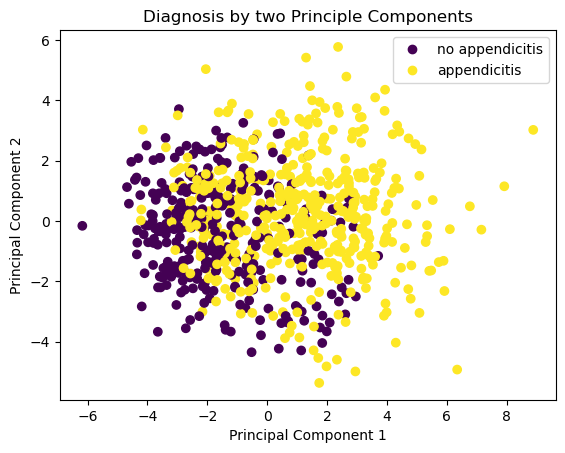

In [32]:
plot = plt.scatter(x=principalDf["pc1"], y=principalDf["pc2"], c=data["Diagnosis"])

plt.legend(handles=plot.legend_elements()[0], labels=['no appendicitis', 'appendicitis'])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Diagnosis by two Principle Components')
plt.show()

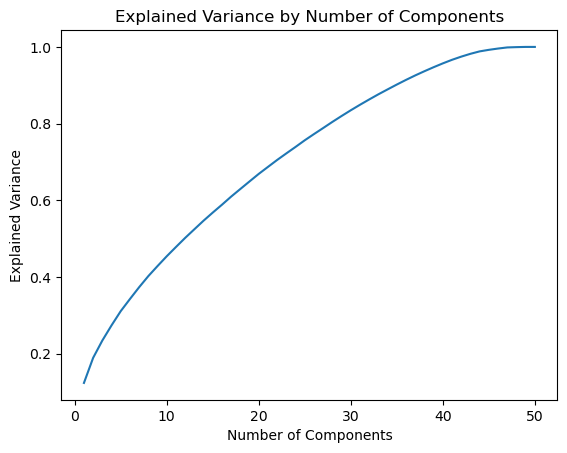

In [12]:
num_comp = []
variance = []

for i in range(1, data_features.shape[1]+1):
    number_comp = i
    
    pca = PCA(n_components=number_comp)
    principalComponents = pca.fit_transform(data_features)
    
    sum_explained_variance = pca.explained_variance_ratio_.sum()
    
    num_comp.append(number_comp)
    variance.append(sum_explained_variance)
    
plt.plot(num_comp, variance)
plt.title('Explained Variance by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')

plt.show()

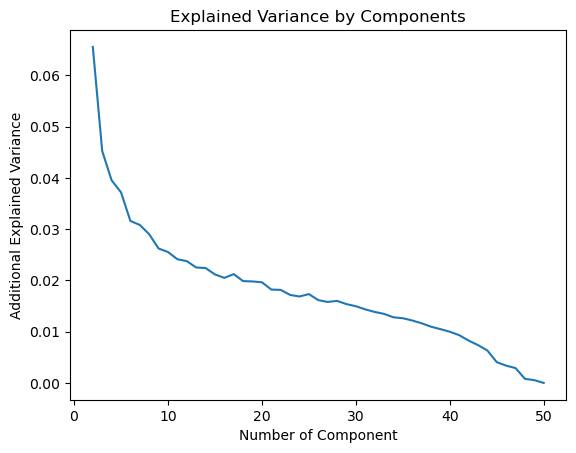

In [13]:
dif = [variance[i+1] - variance[i] for i in range(len(variance)-1)]
xs = np.arange(2,51,1)

plt.plot(xs, dif)
plt.title('Explained Variance by Components')
plt.xlabel('Number of Component')
plt.ylabel('Additional Explained Variance')
plt.show()